In [1]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, PassiveAggressiveRegressor, TheilSenRegressor
from sklearn.multioutput import MultiOutputRegressor

In [2]:
data_train_prepared = pd.read_csv("../processed_data/data_train_prepared.csv")
y_train = pd.read_csv("../processed_data/y_train.csv")
data_test_prepared = pd.read_csv("../processed_data/data_test_prepared.csv")
y_test = pd.read_csv("../processed_data/y_test.csv")

In [3]:
# Only take 10% of the dataset to model faster and already check which model works best

fraction = 0.1
data_train_prepared_sampled = data_train_prepared.sample(frac=fraction, random_state=42)
data_test_prepared_sampled = data_test_prepared.sample(frac=fraction, random_state=42)
y_train_sampled = y_train.sample(frac=fraction, random_state=42)
y_test_sampled = y_test.sample(frac=fraction, random_state=42)

In [4]:
# List of regression model descriptions for plotting

regression_descriptions = [
    'Linear Regression',
    'Ridge Regression',
    'Lasso Regression',
    'ElasticNet Regression',
    'Random Forest Regressor',
    'AdaBoost Regressor',
    'XGBoost Regressor',
    'CatBoost Regressor',
    'Bayesian Ridge',
    'Huber Regressor',
    'Passive Aggressive Regressor',
    'Theil-Sen Regressor',
]

regressors = (
    LinearRegression(),
    Ridge(max_iter=300),
    Lasso(max_iter=300),
    ElasticNet(max_iter=300),
    RandomForestRegressor(n_estimators=300),
    MultiOutputRegressor(AdaBoostRegressor(n_estimators=300)),
    MultiOutputRegressor(XGBRegressor(n_estimators=300)),
    MultiOutputRegressor(CatBoostRegressor(silent=True)),
    MultiOutputRegressor(BayesianRidge(max_iter=300)),
    MultiOutputRegressor(HuberRegressor(max_iter=2000)),
    MultiOutputRegressor(PassiveAggressiveRegressor(max_iter=300)),
    MultiOutputRegressor(TheilSenRegressor(max_iter=300)),
)

In [5]:
# Variables
rand_seed = 42
sample_size = 10000
repetitions = 5

cv_folds = 3
scoring_func = make_scorer(mean_absolute_error)
scoring_func_name = "MAE"

In [6]:
classifier_data = pd.DataFrame([
    {'Regressor': None,
     'Sample size': None,
     'CV folds': None,
     'Raw scores': None,
     'Mean {} score'.format(scoring_func_name): None,
     '{} score SD'.format(scoring_func_name): None,
     'Run time (min.)': None}
] * len(regression_descriptions))    # Create 15 empty rows to use for regressor metrics


ind = 0 # Initialize index to append scores to the dataframe

# Loop over regressors
for regressor, description in zip(regressors, regression_descriptions):
    
    dTs = []
    max_mems = []
    raw_scores = []
    
    for i in range(repetitions):
        
        
        start = time()

        # Cross validate regressor, tracking memory usage
        cross_val_scores = cross_val_score(
            estimator=regressor, 
            X=data_train_prepared_sampled,
            y=y_train_sampled, 
            cv=cv_folds, 
            scoring=scoring_func,
        )

        dT = np.round(((time() - start)/60), 2)
        dTs.append(dT)
        raw_scores = np.concatenate((raw_scores, cross_val_scores))
    

    mean_score = np.round(np.mean(raw_scores), 3)
    sd_score = np.round(np.std(raw_scores), 4)

    
    # Store run results in dataframe

    classifier_data.iloc[ind] = pd.Series([
        description,
        sample_size,
        cv_folds,
        cross_val_scores,
        mean_score,
        sd_score,
        dT
    ], index=classifier_data.columns)
    
    ind += 1
    
    print(f'Finished {description}, mean score: {mean_score}')

# Sort results by score
classifier_data = classifier_data.sort_values(['Mean {} score'.format(scoring_func_name)], ascending=True)

Finished Linear Regression, mean score: 2.202
Finished Ridge Regression, mean score: 2.213
Finished Lasso Regression, mean score: 5.991
Finished ElasticNet Regression, mean score: 7.985
Finished Random Forest Regressor, mean score: 2.314
Finished AdaBoost Regressor, mean score: 5.638
Finished XGBoost Regressor, mean score: 2.158
Finished CatBoost Regressor, mean score: 2.002
Finished Bayesian Ridge, mean score: 2.202
Finished Huber Regressor, mean score: 2.169
Finished Passive Aggressive Regressor, mean score: 3.47
Finished Theil-Sen Regressor, mean score: 2.222


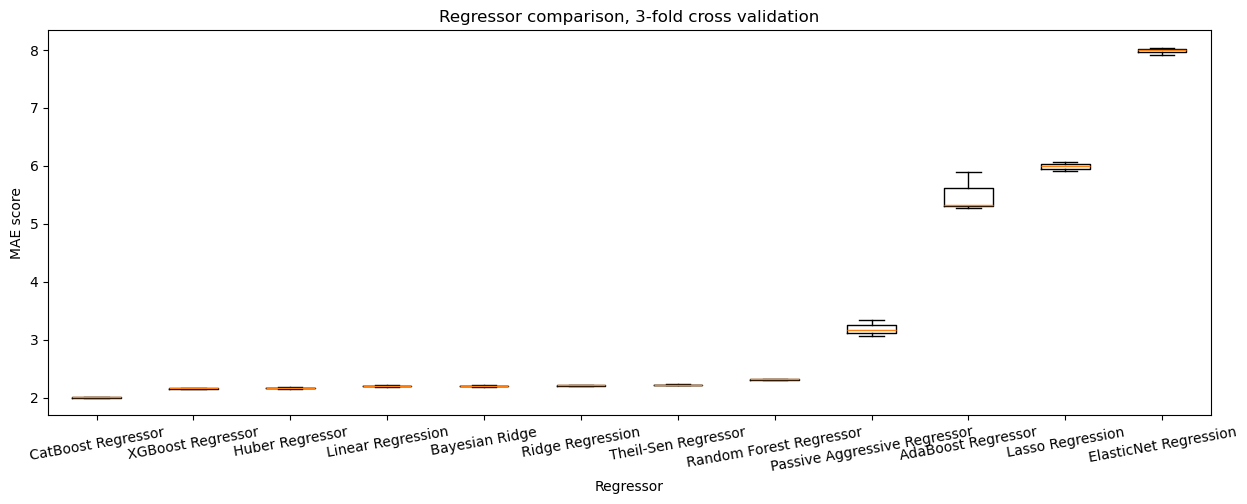

In [9]:
# Plot comparison of regressors using mean score
fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(classifier_data['Raw scores'])
ax.set_xticklabels(classifier_data['Regressor'])
plt.xlabel('Regressor')
plt.ylabel('{} score'.format(scoring_func_name))
plt.title('Regressor comparison, 3-fold cross validation')
plt.xticks(rotation=10)

plt.savefig("all_models_performance", dpi=200)

plt.show()

In [8]:
classifier_data.drop('Raw scores', axis=1)

,Regressor,Sample size,CV folds,Mean MAE score,MAE score SD,Run time (min.)
7,CatBoost Regressor,10000,3,2.002,0.0028,1.91
6,XGBoost Regressor,10000,3,2.158,0.007,0.25
9,Huber Regressor,10000,3,2.169,0.0083,2.82
0,Linear Regression,10000,3,2.202,0.0088,0.0
8,Bayesian Ridge,10000,3,2.202,0.0088,0.01
1,Ridge Regression,10000,3,2.213,0.0069,0.0
11,Theil-Sen Regressor,10000,3,2.222,0.0083,6.01
4,Random Forest Regressor,10000,3,2.314,0.005,11.18
10,Passive Aggressive Regressor,10000,3,3.47,0.4544,0.03
5,AdaBoost Regressor,10000,3,5.638,0.1919,3.62


CatBoost seems to be the best model for our use case, we will now proceed to hyper-parameter tuning.